In [1]:
#!unxz mnist.out.xz

In [2]:
from model import Model
from collections import namedtuple
import sys
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display

In [3]:
random.seed(1)
np.random.seed(1)

Game = namedtuple('Game', ['env_name', 'input_size', 'output_size', 'wann_file', 'action_select', 'weight_bias'])
game = Game(env_name='MNISTTEST784-v0',
  input_size=784,
  output_size=10,
  wann_file='brain-tokyo-workshop/WANNRelease/WANNTool/champions/mnist784_best.out',
  action_select='softmax', # all, soft, hard
  weight_bias=0.0,
)
model = Model(game)
model.make_env()
model.env.seed(1)
model.load_model('brain-tokyo-workshop/WANNRelease/WANNTool/log/mnist784test.cma.4.32.best.json')

batch = model.env.reset()
output = model.get_action(batch)

loading file brain-tokyo-workshop/WANNRelease/WANNTool/log/mnist784test.cma.4.32.best.json


In [4]:
import os
import numpy as np
from skimage.transform import resize

MASK_PATH = os.path.join('rise_masks.npy')

#MASK_COUNT = 500
#s = 8
#p1 = 0.5

MASK_COUNT = 5000
s = 8
p1 = 0.5

def generate_masks(N, s, p1, input_size):
    cell_size = np.ceil(np.array(input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *input_size))

    for i in range(N):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + input_size[0], y:y + input_size[1]]
    masks = masks.reshape(-1, *input_size, 1)
    return masks


def explain(model, inp, masks, input_size):
    batch_size = 100
    preds = []
    # Make sure multiplication is being done for correct axes

    for i in range(0, MASK_COUNT, batch_size):
        sub_masks = masks[i:min(i + batch_size, MASK_COUNT)]
        masked = inp * sub_masks
        o = model.get_action(masked.reshape(batch_size, 28 * 28))
        preds.append(o)
    preds = np.concatenate(preds)
    sal = preds.T.dot(masks.reshape(MASK_COUNT, -1)).reshape(-1, *input_size)
    sal = sal / MASK_COUNT / p1
    return sal


masks = generate_masks(MASK_COUNT, s, p1, (28, 28))

label: 6
prediction label changed at 21 removed pixels


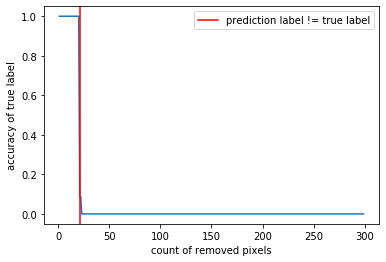

label: 9
prediction label changed at 15 removed pixels


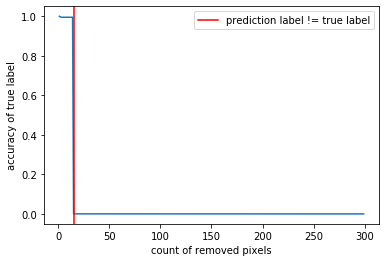

label: 2
prediction label changed at 5 removed pixels


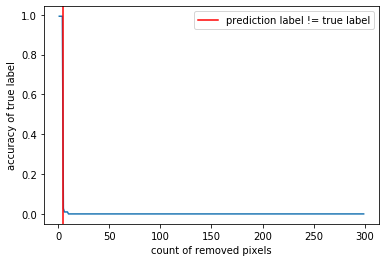

label: 6


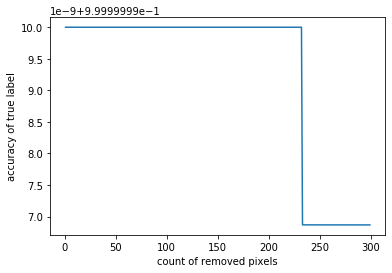

label: 7


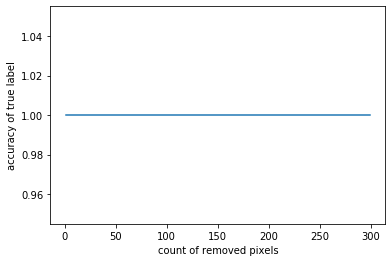

label: 6


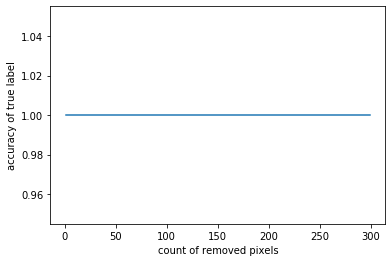

label: 1
prediction label changed at 13 removed pixels


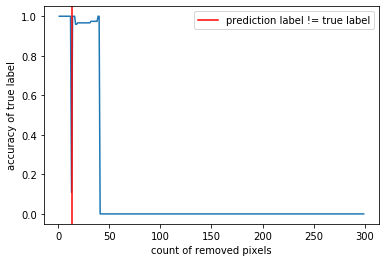

label: 4
Network did not recognize unchanged image, skipping
label: 7
prediction label changed at 4 removed pixels


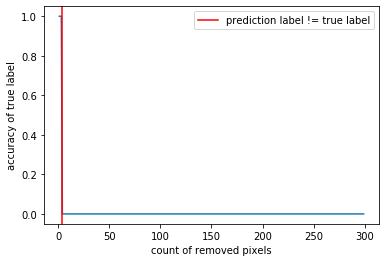

label: 1
prediction label changed at 26 removed pixels


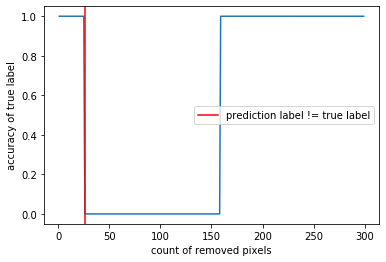

label: 1
prediction label changed at 12 removed pixels


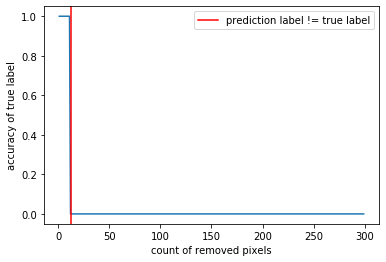

label: 1
prediction label changed at 5 removed pixels


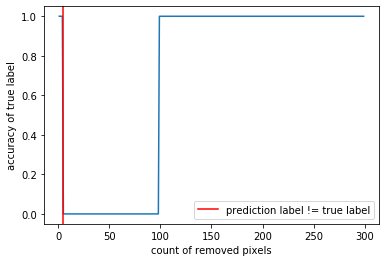

label: 3
prediction label changed at 32 removed pixels


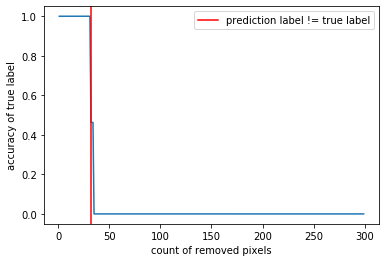

label: 9
prediction label changed at 2 removed pixels


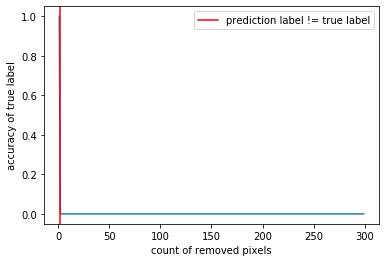

label: 0
prediction label changed at 57 removed pixels


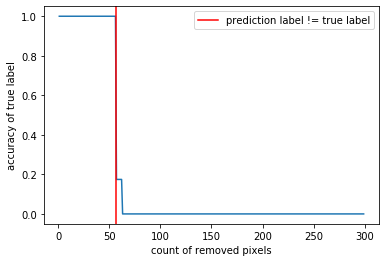

label: 2


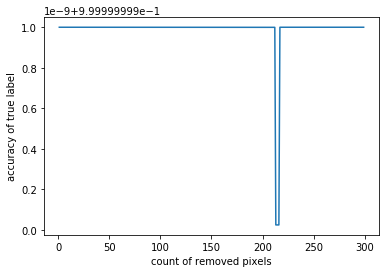

label: 7
prediction label changed at 105 removed pixels


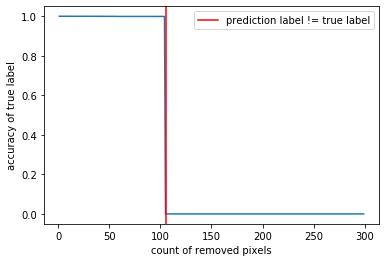

label: 2


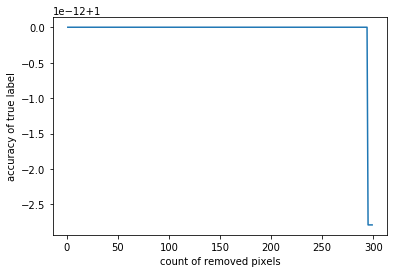

label: 4
prediction label changed at 52 removed pixels


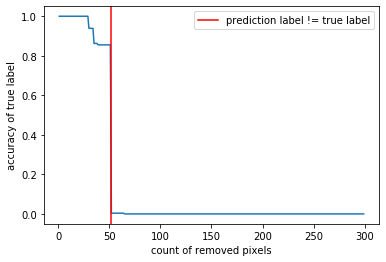

label: 6
prediction label changed at 289 removed pixels


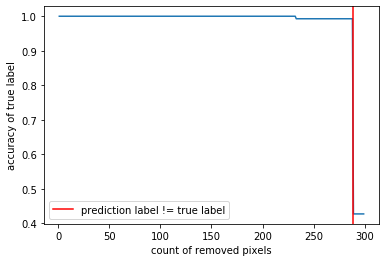

In [5]:
def evaluate(index):
    image = batch[index]

    label = model.env.target[model.env.currIndx][index]

    print('label:', label)

    baseline = model.get_action([batch[index]])
    predicted_label = np.argmax(baseline[0])

    #print('prediction', predicted_label)
    #print(', '.join([f'{x:.5f}' for x in baseline[0]]))

    sal = explain(model, image.reshape(28, 28, 1), masks, (28, 28))

    if predicted_label != label:
        print('Network did not recognize unchanged image, skipping')
        return

    flat = sal[label].reshape(28*28)

    prediction_label_change = None
    accuracies = []
    
    for count in range(1, 300):
        highest_indexes = np.argpartition(flat, -count)[-count:]

        modified_img = np.copy(image.reshape(28 * 28))
        modified_img[highest_indexes] = 0
        new_prediction = model.get_action([modified_img.reshape(28 * 28)])
        accuracies.append(new_prediction[0][label])
        new_prediction_label = np.argmax(new_prediction[0])
        
        if new_prediction_label != label and not prediction_label_change:
            prediction_label_change = count

            
    x = list(range(1, 300))

    plt.plot(x, accuracies)
    plt.ylabel('accuracy of true label')
    plt.xlabel('count of removed pixels')
    if prediction_label_change:
        print(f'prediction label changed at {prediction_label_change} removed pixels')
        plt.axvline(prediction_label_change, label='prediction label != true label', c='red')
        plt.legend()

    plt.show()
    
    display(HTML('<hr>'))
            
for index in range(20):
    evaluate(index)